In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

# 6dFGS

In [8]:
# Load CF4 6dFGS subset
df1 = pd.read_csv("../../data/external/cf4/raw/cf4_6dfgs_subsample.txt")[["pgc", "Name"]].rename({"Name": "survey_id"}, axis=1)

# Load my final 6dFGS
df2 = pd.read_csv("../../data/foundation/distance_modulus/6dfgs.csv")[["survey_id"]]

# Get PGC (cross match by 6dFGS ID)
df = df2.merge(df1, on="survey_id", how="inner")

# Save
df.to_csv("../../data/external/pgc/6dfgs.csv", index=False)

# SDSS

In [17]:
# Load CF4 SDSS subset
df1 = pd.read_csv("../../data/external/cf4/raw/cf4_sdss_subsample.txt")[["pgc", "objid"]].rename({"objid": "survey_id"}, axis=1)
df1["survey_id"] = df1["survey_id"].apply(lambda x: "SDSS" + str(x))

# Load my final SDSS
df2 = pd.read_csv("../../data/foundation/distance_modulus/sdss.csv")[["survey_id"]]

# Get PGC (cross match by SDSS ID)
df = df2.merge(df1, on="survey_id", how="inner")

# Save
df.to_csv("../../data/external/pgc/sdss.csv", index=False)

# LAMOST (sky cross-matching)

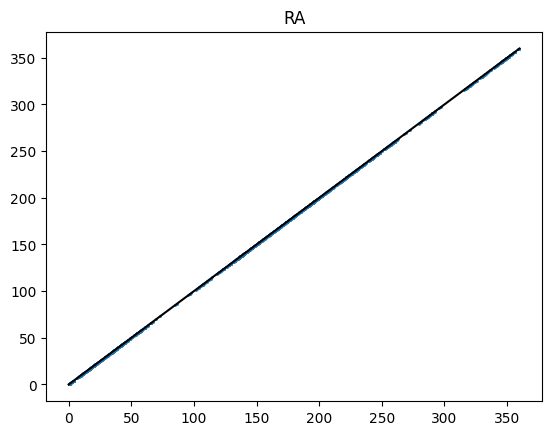

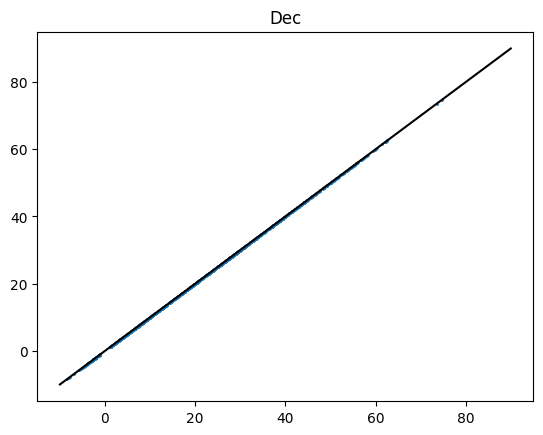

In [101]:
# Load HyperLEDA PGC
df1 = pd.read_csv("../../data/external/pgc/leda.txt", sep="\t")

# Parse RA and convert to degrees
df1["RA_hh"] = df1["RAJ2000"].apply(lambda x: x.split(" ")[0]).astype(float)
df1["RA_mm"] = df1["RAJ2000"].apply(lambda x: x.split(" ")[1]).astype(float) / 60
df1["RA_ss"] = df1["RAJ2000"].apply(lambda x: x.split(" ")[2]).astype(float) / 3600
df1["ra"] = 15 * (df1["RA_hh"] + df1["RA_mm"] + df1["RA_ss"])

# Parse Dec
df1["Dec_sign"] = df1["DEJ2000"].apply(lambda x: np.sign(float(x.split(" ")[0])))
df1["Dec_d"] = np.absolute(df1["DEJ2000"].apply(lambda x: x.split(" ")[0]).astype(float))
df1["Dec_m"] = np.absolute(df1["DEJ2000"].apply(lambda x: x.split(" ")[1]).astype(float) / 60)
df1["Dec_s"] = np.absolute(df1["DEJ2000"].apply(lambda x: x.split(" ")[2]).astype(float) / 3600)
df1["dec"] = df1["Dec_sign"] * (df1["Dec_d"] + df1["Dec_m"] + df1["Dec_s"])
df1 = df1[["PGC", "ra", "dec"]].rename({"PGC": "pgc"}, axis=1)

# Load LAMOST data
df2 = pd.read_csv("../../data/foundation/distance_modulus/lamost.csv")[["survey_id", "ra", "dec"]]

# Crossmatch LEDA data with my LAMOST data based on individual galaxy RA and DEC
coords_cf4 = SkyCoord(ra=df1['ra'].to_numpy() * u.deg, dec=df1['dec'].to_numpy() * u.deg)
coords_mydata = SkyCoord(ra=df2['ra'].to_numpy() * u.deg, dec=df2['dec'].to_numpy() * u.deg)

idx, sep2d, _ = coords_mydata.match_to_catalog_sky(coords_cf4)
SEP_THRESH = 5
is_counterpart = sep2d < SEP_THRESH * u.arcsec

df2['leda_idx'] = idx
df2['leda_counterpart'] = is_counterpart
df2 = df2[df2["leda_counterpart"]]

df = df2.merge(df1, left_on='leda_idx', how='left', right_index=True)

# Plot RA and Dec
plt.figure()
plt.title("RA")
plt.scatter(df["ra_x"], df["ra_y"], s=1)
plt.plot([0, 360], [0, 360], c='k')

plt.figure()
plt.title("Dec")
plt.scatter(df["dec_x"], df["dec_y"], s=1)
plt.plot([-10, 90], [-10, 90], c='k')

df = df[["pgc", "survey_id"]]
df.to_csv("../../data/external/pgc/lamost.csv", index=False)